In [1]:
# 1: Load Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import (
    ttest_ind, ttest_rel, f_oneway, chi2_contingency,
    normaltest, shapiro, levene, mannwhitneyu, kruskal,
    pearsonr, spearmanr, kendalltau
)
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.power import TTestIndPower
import sys
import os
import warnings
warnings.filterwarnings('ignore')

PROJECT_ROOT = os.path.abspath("..")
sys.path.append(PROJECT_ROOT)
from scripts.utils import execute_query

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("Libraries loaded successfully")

Libraries loaded successfully


In [2]:
# 2: Load Data
print("Loading data from Snowflake MARTS layer...")

query = """
SELECT 
    *
FROM MARTS.FCT_WEATHER_DAILY
WHERE date >= '2023-01-01'
ORDER BY date
"""

df = execute_query(query, config_path='../config/snowflake_config.json')
df['date'] = pd.to_datetime(df['date'])

print(f"✅ Loaded {len(df):,} records")
print(f"📊 Date range: {df['date'].min()} to {df['date'].max()}")
print(f"📍 Locations: {df['location_name'].unique()}")

Loading data from Snowflake MARTS layer...
🔍 Executing query...
✅ Query returned 3,655 rows
✅ Loaded 3,655 records
📊 Date range: 2024-01-22 00:00:00 to 2026-01-21 00:00:00
📍 Locations: ['Can Tho' 'Hanoi' 'Da Nang' 'Hai Phong' 'Ho Chi Minh City']


In [3]:
# 3: Data Preparation
print("=" * 80)
print("DATA PREPARATION FOR STATISTICAL TESTS")
print("=" * 80)

# Separate data by season
dry_season = df[df['season'] == 'Dry Season']
rainy_season = df[df['season'] == 'Rainy Season']

print(f"\nDry Season records: {len(dry_season):,}")
print(f"Rainy Season records: {len(rainy_season):,}")

# Separate data by location
locations = {}
for loc in df['location_name'].unique():
    locations[loc] = df[df['location_name'] == loc]
    print(f"{loc}: {len(locations[loc]):,} records")

# Create month groups
df['month_GROUP'] = df['month'].apply(lambda x: 
    'Q1' if x in [1,2,3] else
    'Q2' if x in [4,5,6] else
    'Q3' if x in [7,8,9] else 'Q4'
)

DATA PREPARATION FOR STATISTICAL TESTS

Dry Season records: 1,815
Rainy Season records: 1,840
Can Tho: 731 records
Hanoi: 731 records
Da Nang: 731 records
Hai Phong: 731 records
Ho Chi Minh City: 731 records


TEST 1: NORMALITY TESTS

Normality Test Results:


,Variable,Shapiro_Statistic,Shapiro_p_value,Shapiro_Normal,K2_Statistic,K2_p_value,K2_Normal
0,avg_temperature,0.901854,1.804688e-43,No,723.212333,9.045597e-158,No
1,total_precipitation,0.511986,2.808078e-72,No,4078.314071,0.000000e+00,No
2,avg_humidity,0.928283,1.032599e-38,No,373.068031,9.756777e-82,No
3,avg_pressure,0.984894,2.469391e-19,No,97.647316,6.253955e-22,No
4,avg_wind_speed,0.920004,2.453082e-40,No,1142.216328,9.351383e-249,No


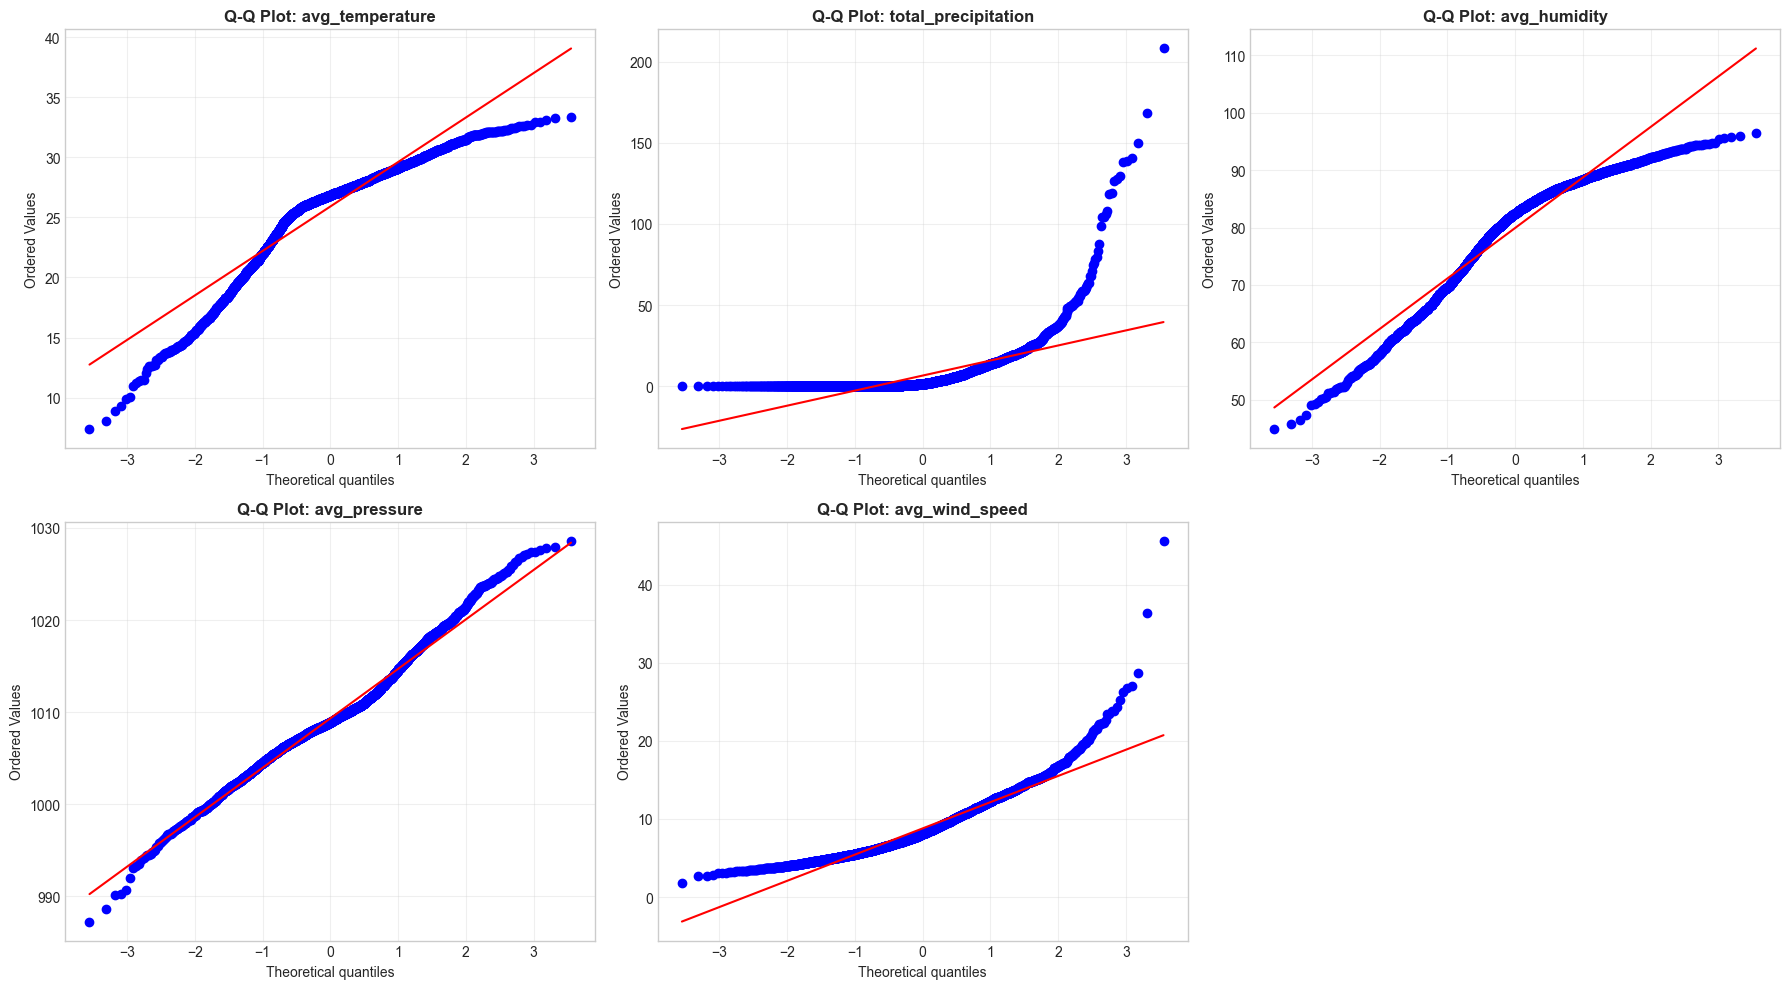


📊 Interpretation:
If p-value > 0.05: Data is normally distributed
If p-value ≤ 0.05: Data is NOT normally distributed


In [4]:
# 4: Test for Normality
print("=" * 80)
print("TEST 1: NORMALITY TESTS")
print("=" * 80)

variables = ['avg_temperature', 'total_precipitation', 'avg_humidity', 
             'avg_pressure', 'avg_wind_speed']

normality_results = []

for var in variables:
    # Shapiro-Wilk test (for sample size < 5000)
    sample = df[var].dropna().sample(min(5000, len(df[var].dropna())), random_state=42)
    shapiro_stat, shapiro_p = shapiro(sample)
    
    # D'Agostino's K-squared test
    k2_stat, k2_p = normaltest(df[var].dropna())
    
    normality_results.append({
        'Variable': var,
        'Shapiro_Statistic': shapiro_stat,
        'Shapiro_p_value': shapiro_p,
        'Shapiro_Normal': 'Yes' if shapiro_p > 0.05 else 'No',
        'K2_Statistic': k2_stat,
        'K2_p_value': k2_p,
        'K2_Normal': 'Yes' if k2_p > 0.05 else 'No'
    })

normality_df = pd.DataFrame(normality_results)
print("\nNormality Test Results:")
display(normality_df)

# Visualize distributions with Q-Q plots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, var in enumerate(variables):
    stats.probplot(df[var].dropna(), dist="norm", plot=axes[idx])
    axes[idx].set_title(f'Q-Q Plot: {var}', fontweight='bold')
    axes[idx].grid(alpha=0.3)

# Remove extra subplot
fig.delaxes(axes[-1])
plt.tight_layout()
plt.show()

print("\n📊 Interpretation:")
print("If p-value > 0.05: Data is normally distributed")
print("If p-value ≤ 0.05: Data is NOT normally distributed")

TEST 2: TEMPERATURE DIFFERENCE BETWEEN seasonS

Levene's Test for Equal Variances:
  Statistic: 948.8965
  p-value: 0.0000
  Equal variances: No

Independent T-Test:
  t-statistic: -33.4378
  p-value: 0.000000
  Significant difference: Yes

Mann-Whitney U Test (Non-parametric):
  U-statistic: 776321.5000
  p-value: 0.000000
  Significant difference: Yes

Effect Size (Cohen's d): -1.1116
Interpretation: Large effect

Descriptive Statistics:
  Dry Season - Mean: 24.00°C, SD: 4.46°C
  Rainy Season - Mean: 27.78°C, SD: 1.85°C
  Difference: -3.79°C


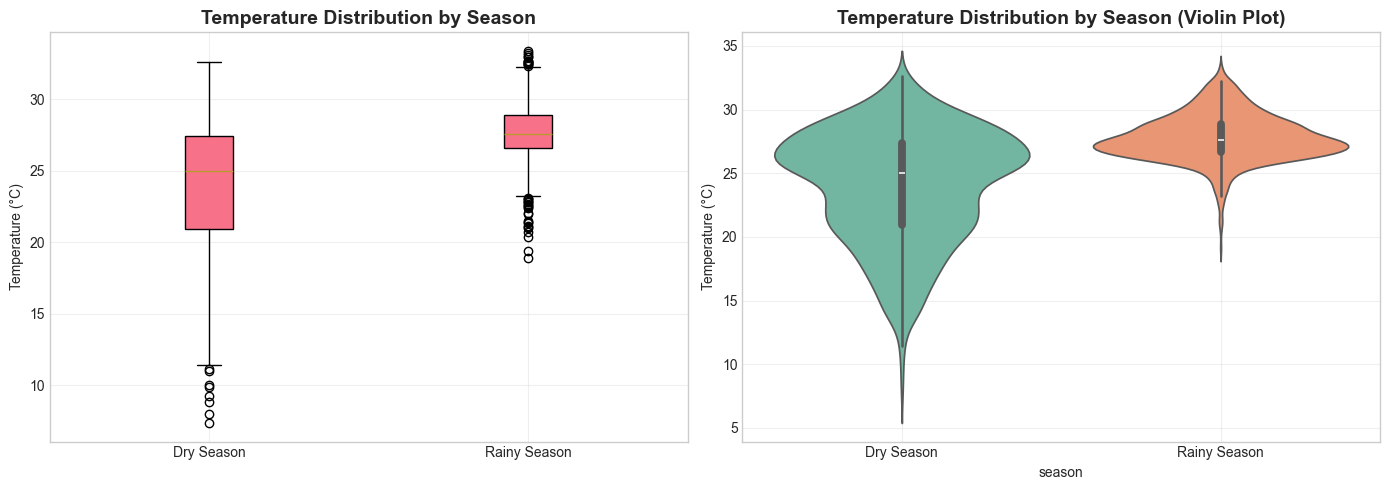

In [5]:
# 5: Hypothesis Test 1 - Temperature Difference Between Seasons
print("=" * 80)
print("TEST 2: TEMPERATURE DIFFERENCE BETWEEN seasonS")
print("=" * 80)

# H0: Mean temperature in dry season = Mean temperature in rainy season
# H1: Mean temperature in dry season ≠ Mean temperature in rainy season

dry_temp = dry_season['avg_temperature'].dropna()
rainy_temp = rainy_season['avg_temperature'].dropna()

# Check variance equality (Levene's test)
levene_stat, levene_p = levene(dry_temp, rainy_temp)
print(f"\nLevene's Test for Equal Variances:")
print(f"  Statistic: {levene_stat:.4f}")
print(f"  p-value: {levene_p:.4f}")
print(f"  Equal variances: {'Yes' if levene_p > 0.05 else 'No'}")

# T-test (independent samples)
t_stat, t_p = ttest_ind(dry_temp, rainy_temp, equal_var=(levene_p > 0.05))

# Mann-Whitney U test (non-parametric alternative)
u_stat, u_p = mannwhitneyu(dry_temp, rainy_temp, alternative='two-sided')

print(f"\nIndependent T-Test:")
print(f"  t-statistic: {t_stat:.4f}")
print(f"  p-value: {t_p:.6f}")
print(f"  Significant difference: {'Yes' if t_p < 0.05 else 'No'}")

print(f"\nMann-Whitney U Test (Non-parametric):")
print(f"  U-statistic: {u_stat:.4f}")
print(f"  p-value: {u_p:.6f}")
print(f"  Significant difference: {'Yes' if u_p < 0.05 else 'No'}")

# Effect size (Cohen's d)
cohens_d = (dry_temp.mean() - rainy_temp.mean()) / np.sqrt(
    ((len(dry_temp)-1)*dry_temp.std()**2 + (len(rainy_temp)-1)*rainy_temp.std()**2) / 
    (len(dry_temp) + len(rainy_temp) - 2)
)

print(f"\nEffect Size (Cohen's d): {cohens_d:.4f}")
print(f"Interpretation: ", end="")
if abs(cohens_d) < 0.2:
    print("Small effect")
elif abs(cohens_d) < 0.5:
    print("Medium effect")
else:
    print("Large effect")

# Descriptive statistics
print(f"\nDescriptive Statistics:")
print(f"  Dry Season - Mean: {dry_temp.mean():.2f}°C, SD: {dry_temp.std():.2f}°C")
print(f"  Rainy Season - Mean: {rainy_temp.mean():.2f}°C, SD: {rainy_temp.std():.2f}°C")
print(f"  Difference: {dry_temp.mean() - rainy_temp.mean():.2f}°C")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box plot
seasons_data = [dry_temp, rainy_temp]
axes[0].boxplot(seasons_data, labels=['Dry Season', 'Rainy Season'], patch_artist=True)
axes[0].set_title('Temperature Distribution by Season', fontweight='bold', fontsize=14)
axes[0].set_ylabel('Temperature (°C)')
axes[0].grid(alpha=0.3)

# Violin plot
sns.violinplot(data=df, x='season', y='avg_temperature', ax=axes[1], palette='Set2')
axes[1].set_title('Temperature Distribution by Season (Violin Plot)', fontweight='bold', fontsize=14)
axes[1].set_ylabel('Temperature (°C)')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

TEST 3: TEMPERATURE DIFFERENCES ACROSS LOCATIONS (ANOVA)

One-Way ANOVA:
  F-statistic: 157.2866
  p-value: 0.000000
  Significant difference: Yes

Kruskal-Wallis Test (Non-parametric):
  H-statistic: 308.6993
  p-value: 0.000000
  Significant difference: Yes

📊 Performing Post-Hoc Test (Tukey HSD)...

Tukey HSD Results:
       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
  group1       group2      meandiff p-adj   lower   upper  reject
-----------------------------------------------------------------
  Can Tho          Da Nang    -0.86 0.0001 -1.3739 -0.3462   True
  Can Tho        Hai Phong  -3.0079    0.0 -3.5218 -2.4941   True
  Can Tho            Hanoi  -3.0023    0.0 -3.5161 -2.4884   True
  Can Tho Ho Chi Minh City   0.5605 0.0245  0.0466  1.0743   True
  Da Nang        Hai Phong  -2.1479    0.0 -2.6617  -1.634   True
  Da Nang            Hanoi  -2.1422    0.0 -2.6561 -1.6284   True
  Da Nang Ho Chi Minh City   1.4205    0.0  0.9066  1.9344   True
Hai Phong        

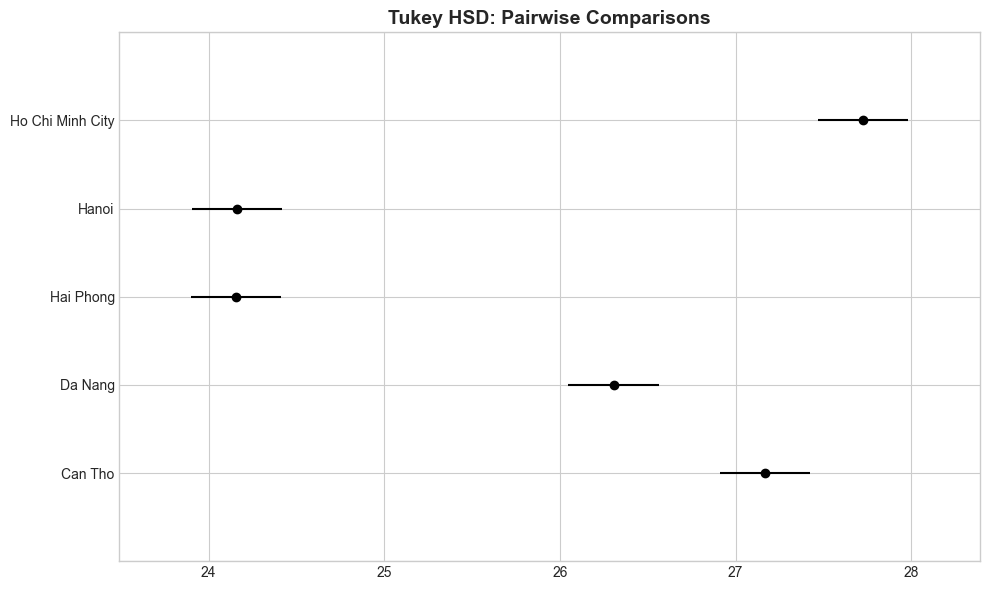


Descriptive Statistics by Location:


,mean,std,count
location_name,,,
Can Tho,27.17,1.47,731
Da Nang,26.31,3.44,731
Hai Phong,24.16,4.87,731
Hanoi,24.16,4.97,731
Ho Chi Minh City,27.73,1.53,731


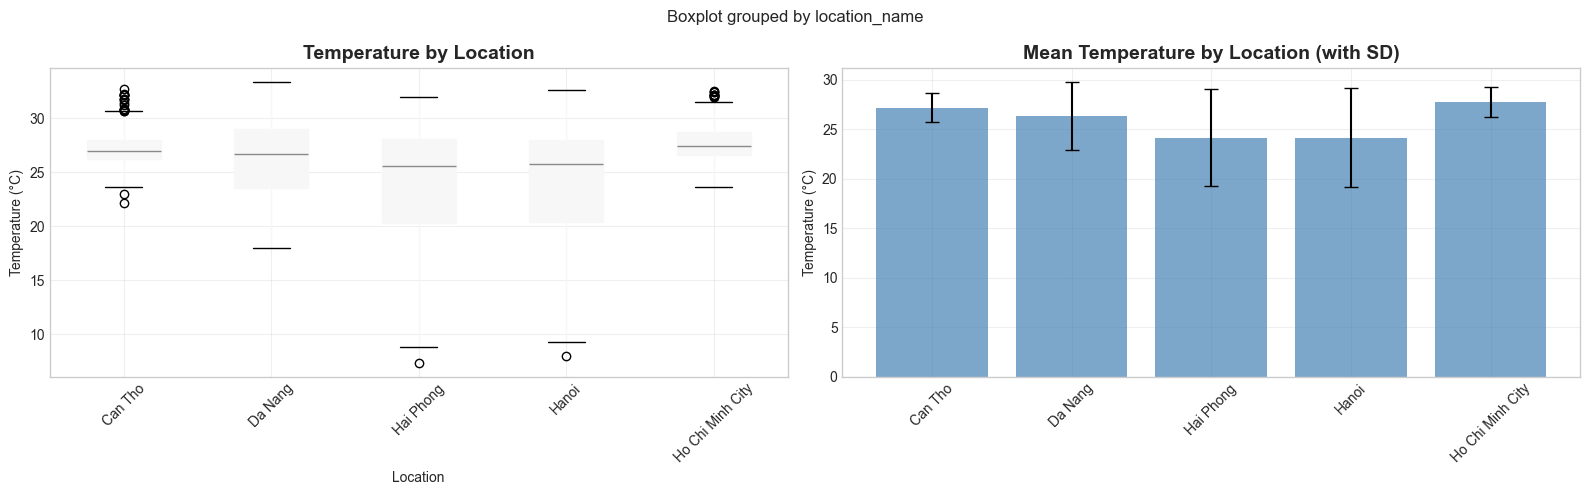

In [6]:
# 6: Hypothesis Test 2 - ANOVA for Temperature Across Locations
print("=" * 80)
print("TEST 3: TEMPERATURE DIFFERENCES ACROSS LOCATIONS (ANOVA)")
print("=" * 80)

# H0: All locations have the same mean temperature
# H1: At least one location has a different mean temperature

location_temps = [locations[loc]['avg_temperature'].dropna() for loc in locations.keys()]

# One-way ANOVA
f_stat, anova_p = f_oneway(*location_temps)

# Kruskal-Wallis test (non-parametric alternative)
h_stat, kruskal_p = kruskal(*location_temps)

print(f"\nOne-Way ANOVA:")
print(f"  F-statistic: {f_stat:.4f}")
print(f"  p-value: {anova_p:.6f}")
print(f"  Significant difference: {'Yes' if anova_p < 0.05 else 'No'}")

print(f"\nKruskal-Wallis Test (Non-parametric):")
print(f"  H-statistic: {h_stat:.4f}")
print(f"  p-value: {kruskal_p:.6f}")
print(f"  Significant difference: {'Yes' if kruskal_p < 0.05 else 'No'}")

# Post-hoc test: Tukey HSD
if anova_p < 0.05:
    print("\n📊 Performing Post-Hoc Test (Tukey HSD)...")
    
    tukey_data = df[['location_name', 'avg_temperature']].dropna()
    tukey_result = pairwise_tukeyhsd(
        endog=tukey_data['avg_temperature'],
        groups=tukey_data['location_name'],
        alpha=0.05
    )
    
    print("\nTukey HSD Results:")
    print(tukey_result)
    
    # Visualize Tukey results
    fig, ax = plt.subplots(figsize=(10, 6))
    tukey_result.plot_simultaneous(ax=ax)
    plt.title('Tukey HSD: Pairwise Comparisons', fontweight='bold', fontsize=14)
    plt.tight_layout()
    plt.show()

# Descriptive statistics by location
print("\nDescriptive Statistics by Location:")
location_stats = df.groupby('location_name')['avg_temperature'].agg(['mean', 'std', 'count'])
display(location_stats.round(2))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Box plot
df.boxplot(column='avg_temperature', by='location_name', ax=axes[0], patch_artist=True)
axes[0].set_title('Temperature by Location', fontweight='bold', fontsize=14)
axes[0].set_xlabel('Location')
axes[0].set_ylabel('Temperature (°C)')
plt.sca(axes[0])
plt.xticks(rotation=45)
axes[0].grid(alpha=0.3)

# Bar plot with error bars
location_means = df.groupby('location_name')['avg_temperature'].mean()
location_stds = df.groupby('location_name')['avg_temperature'].std()
axes[1].bar(range(len(location_means)), location_means.values, 
           yerr=location_stds.values, capsize=5, alpha=0.7, color='steelblue')
axes[1].set_xticks(range(len(location_means)))
axes[1].set_xticklabels(location_means.index, rotation=45)
axes[1].set_title('Mean Temperature by Location (with SD)', fontweight='bold', fontsize=14)
axes[1].set_ylabel('Temperature (°C)')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

TEST 4: PRECIPITATION DIFFERENCE BETWEEN seasonS

Mann-Whitney U Test:
  U-statistic: 687448.0000
  p-value: 0.000000
  Significant difference: Yes

Descriptive Statistics:
  Dry Season - Median: 0.20 mm, Mean: 2.59 mm
  Rainy Season - Median: 5.90 mm, Mean: 10.46 mm
  Difference in medians: 5.70 mm

Proportion Test (Days with Rain):
  Dry Season: 1053/1815 (58.0%)
  Rainy Season: 1694/1840 (92.1%)
  z-statistic: -23.8188
  p-value: 0.000000
  Significant difference: Yes


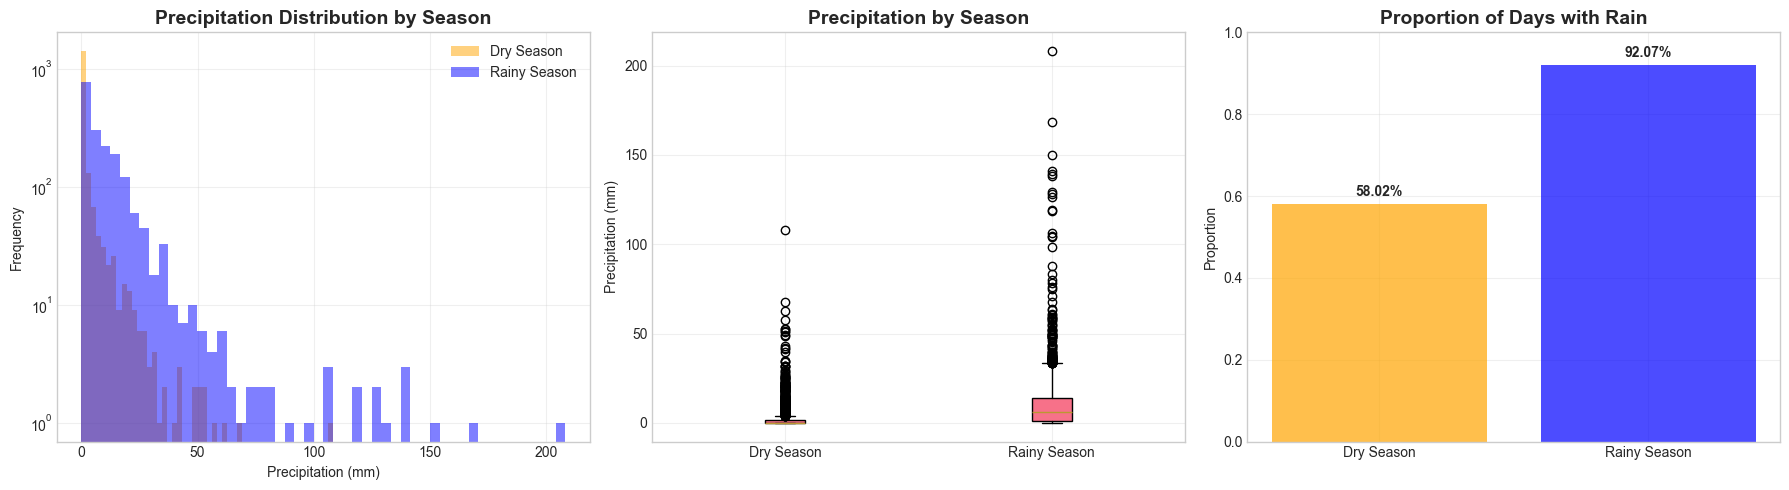

In [7]:
# 7: Hypothesis Test 3 - Precipitation Patterns
print("=" * 80)
print("TEST 4: PRECIPITATION DIFFERENCE BETWEEN seasonS")
print("=" * 80)

# H0: Precipitation is the same in both seasons
# H1: Precipitation differs between seasons

dry_precip = dry_season['total_precipitation'].dropna()
rainy_precip = rainy_season['total_precipitation'].dropna()

# Mann-Whitney U test (precipitation is not normally distributed)
u_stat, u_p = mannwhitneyu(dry_precip, rainy_precip, alternative='two-sided')

print(f"\nMann-Whitney U Test:")
print(f"  U-statistic: {u_stat:.4f}")
print(f"  p-value: {u_p:.6f}")
print(f"  Significant difference: {'Yes' if u_p < 0.05 else 'No'}")

print(f"\nDescriptive Statistics:")
print(f"  Dry Season - Median: {dry_precip.median():.2f} mm, Mean: {dry_precip.mean():.2f} mm")
print(f"  Rainy Season - Median: {rainy_precip.median():.2f} mm, Mean: {rainy_precip.mean():.2f} mm")
print(f"  Difference in medians: {rainy_precip.median() - dry_precip.median():.2f} mm")

# Proportion test: Days with rain
dry_rainy_days = (dry_season['total_precipitation'] > 0).sum()
rainy_rainy_days = (rainy_season['total_precipitation'] > 0).sum()

count = np.array([dry_rainy_days, rainy_rainy_days])
nobs = np.array([len(dry_season), len(rainy_season)])

z_stat, prop_p = proportions_ztest(count, nobs)

print(f"\nProportion Test (Days with Rain):")
print(f"  Dry Season: {dry_rainy_days}/{len(dry_season)} ({dry_rainy_days/len(dry_season)*100:.1f}%)")
print(f"  Rainy Season: {rainy_rainy_days}/{len(rainy_season)} ({rainy_rainy_days/len(rainy_season)*100:.1f}%)")
print(f"  z-statistic: {z_stat:.4f}")
print(f"  p-value: {prop_p:.6f}")
print(f"  Significant difference: {'Yes' if prop_p < 0.05 else 'No'}")

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histogram
axes[0].hist(dry_precip, bins=50, alpha=0.5, label='Dry Season', color='orange')
axes[0].hist(rainy_precip, bins=50, alpha=0.5, label='Rainy Season', color='blue')
axes[0].set_title('Precipitation Distribution by Season', fontweight='bold', fontsize=14)
axes[0].set_xlabel('Precipitation (mm)')
axes[0].set_ylabel('Frequency')
axes[0].legend()
axes[0].set_yscale('log')
axes[0].grid(alpha=0.3)

# Box plot
seasons_precip = [dry_precip, rainy_precip]
axes[1].boxplot(seasons_precip, labels=['Dry Season', 'Rainy Season'], patch_artist=True)
axes[1].set_title('Precipitation by Season', fontweight='bold', fontsize=14)
axes[1].set_ylabel('Precipitation (mm)')
axes[1].grid(alpha=0.3)

# Bar plot - proportion with rain
proportions = [dry_rainy_days/len(dry_season), rainy_rainy_days/len(rainy_season)]
axes[2].bar(['Dry Season', 'Rainy Season'], proportions, color=['orange', 'blue'], alpha=0.7)
axes[2].set_title('Proportion of Days with Rain', fontweight='bold', fontsize=14)
axes[2].set_ylabel('Proportion')
axes[2].set_ylim([0, 1])
axes[2].grid(alpha=0.3)

for i, v in enumerate(proportions):
    axes[2].text(i, v + 0.02, f'{v:.2%}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

TEST 5: CORRELATION ANALYSIS

Correlation Test Results:


,Variable 1,Variable 2,Pearson_r,Pearson_p,Spearman_r,Spearman_p,Kendall_tau,Kendall_p,Significant
0,avg_temperature,avg_humidity,0.0613,0.0002,-0.1864,0.0000,-0.1545,0.0000,Yes
1,avg_temperature,total_precipitation,0.0569,0.0006,0.0551,0.0009,0.0226,0.0464,Yes
2,avg_temperature,avg_pressure,-0.7881,0.0000,-0.7106,0.0000,-0.5322,0.0000,Yes
3,avg_humidity,total_precipitation,0.4145,0.0000,0.7106,0.0000,0.5328,0.0000,Yes
4,avg_wind_speed,total_precipitation,0.1947,0.0000,-0.0225,0.1731,-0.0156,0.1682,Yes


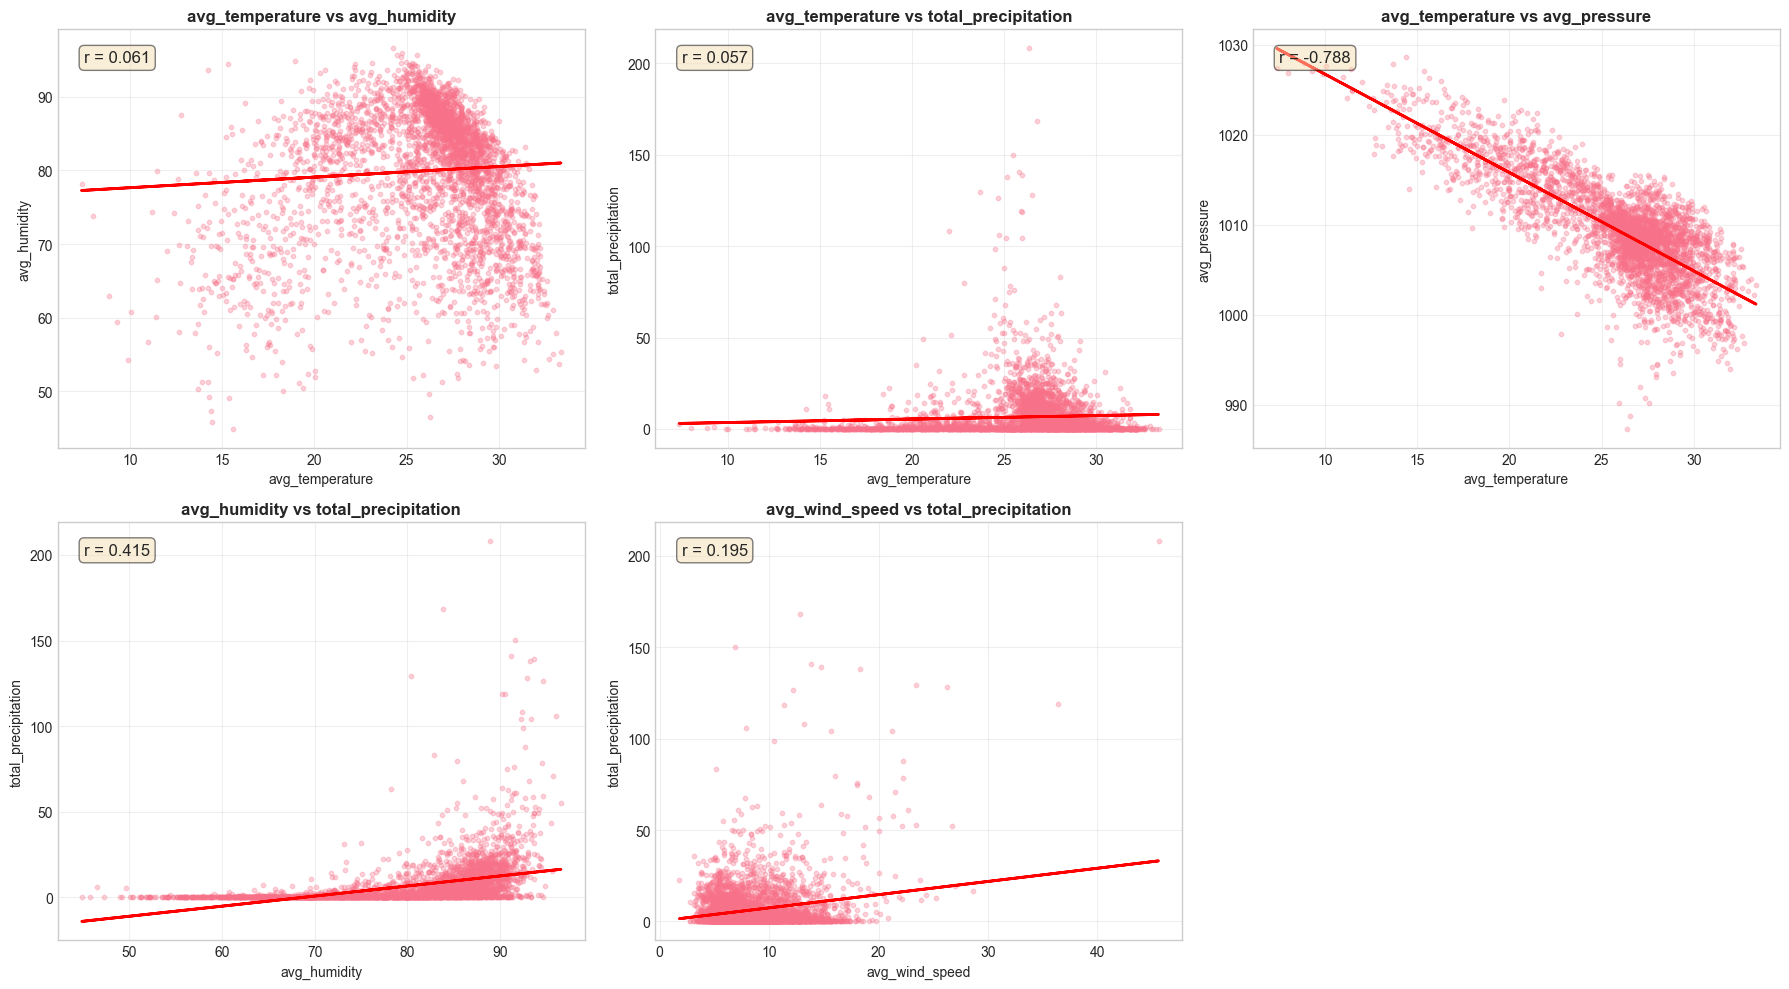


📊 Interpretation:
Pearson r: -1 (perfect negative) to +1 (perfect positive)
If p-value < 0.05: Correlation is statistically significant
|r| < 0.3: Weak correlation
0.3 ≤ |r| < 0.7: Moderate correlation
|r| ≥ 0.7: Strong correlation


In [8]:
# 8: Correlation Tests
print("=" * 80)
print("TEST 5: CORRELATION ANALYSIS")
print("=" * 80)

# Test correlations between weather variables
variables = [
    ('avg_temperature', 'avg_humidity'),
    ('avg_temperature', 'total_precipitation'),
    ('avg_temperature', 'avg_pressure'),
    ('avg_humidity', 'total_precipitation'),
    ('avg_wind_speed', 'total_precipitation')
]

correlation_results = []

for var1, var2 in variables:
    data1 = df[var1].dropna()
    data2 = df[var2].dropna()
    
    # Ensure same length
    common_idx = df[[var1, var2]].dropna().index
    data1 = df.loc[common_idx, var1]
    data2 = df.loc[common_idx, var2]
    
    # Pearson correlation
    pearson_r, pearson_p = pearsonr(data1, data2)
    
    # Spearman correlation (rank-based, more robust)
    spearman_r, spearman_p = spearmanr(data1, data2)
    
    # Kendall's tau
    kendall_tau, kendall_p = kendalltau(data1, data2)
    
    correlation_results.append({
        'Variable 1': var1,
        'Variable 2': var2,
        'Pearson_r': pearson_r,
        'Pearson_p': pearson_p,
        'Spearman_r': spearman_r,
        'Spearman_p': spearman_p,
        'Kendall_tau': kendall_tau,
        'Kendall_p': kendall_p,
        'Significant': 'Yes' if pearson_p < 0.05 else 'No'
    })

corr_df = pd.DataFrame(correlation_results)
print("\nCorrelation Test Results:")
display(corr_df.round(4))

# Visualize correlations
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, (var1, var2) in enumerate(variables):
    common_idx = df[[var1, var2]].dropna().index
    x = df.loc[common_idx, var1]
    y = df.loc[common_idx, var2]
    
    axes[idx].scatter(x, y, alpha=0.3, s=10)
    
    # Add regression line
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    axes[idx].plot(x, p(x), "r-", linewidth=2)
    
    # Add correlation coefficient
    r, _ = pearsonr(x, y)
    axes[idx].text(0.05, 0.95, f'r = {r:.3f}', transform=axes[idx].transAxes,
                  fontsize=12, verticalalignment='top',
                  bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    axes[idx].set_xlabel(var1)
    axes[idx].set_ylabel(var2)
    axes[idx].set_title(f'{var1} vs {var2}', fontweight='bold')
    axes[idx].grid(alpha=0.3)

# Remove extra subplot
fig.delaxes(axes[-1])
plt.tight_layout()
plt.show()

print("\n📊 Interpretation:")
print("Pearson r: -1 (perfect negative) to +1 (perfect positive)")
print("If p-value < 0.05: Correlation is statistically significant")
print("|r| < 0.3: Weak correlation")
print("0.3 ≤ |r| < 0.7: Moderate correlation")
print("|r| ≥ 0.7: Strong correlation")

TEST 6: CONFIDENCE INTERVALS

95% Confidence Intervals by Location:


,Location,Temp_Mean,Temp_CI_Lower,Temp_CI_Upper,Precip_Mean,Precip_CI_Lower,Precip_CI_Upper,Humidity_Mean,Humidity_CI_Lower,Humidity_CI_Upper
0,Can Tho,27.17,27.06,27.27,6.30,5.73,6.86,81.45,80.87,82.04
1,Hanoi,24.16,23.80,24.52,6.80,5.77,7.84,79.03,78.32,79.74
2,Da Nang,26.31,26.06,26.56,7.31,6.04,8.58,81.19,80.64,81.74
3,Hai Phong,24.16,23.80,24.51,5.77,4.76,6.79,80.30,79.65,80.95
4,Ho Chi Minh City,27.73,27.62,27.84,6.57,5.95,7.20,77.69,76.94,78.45


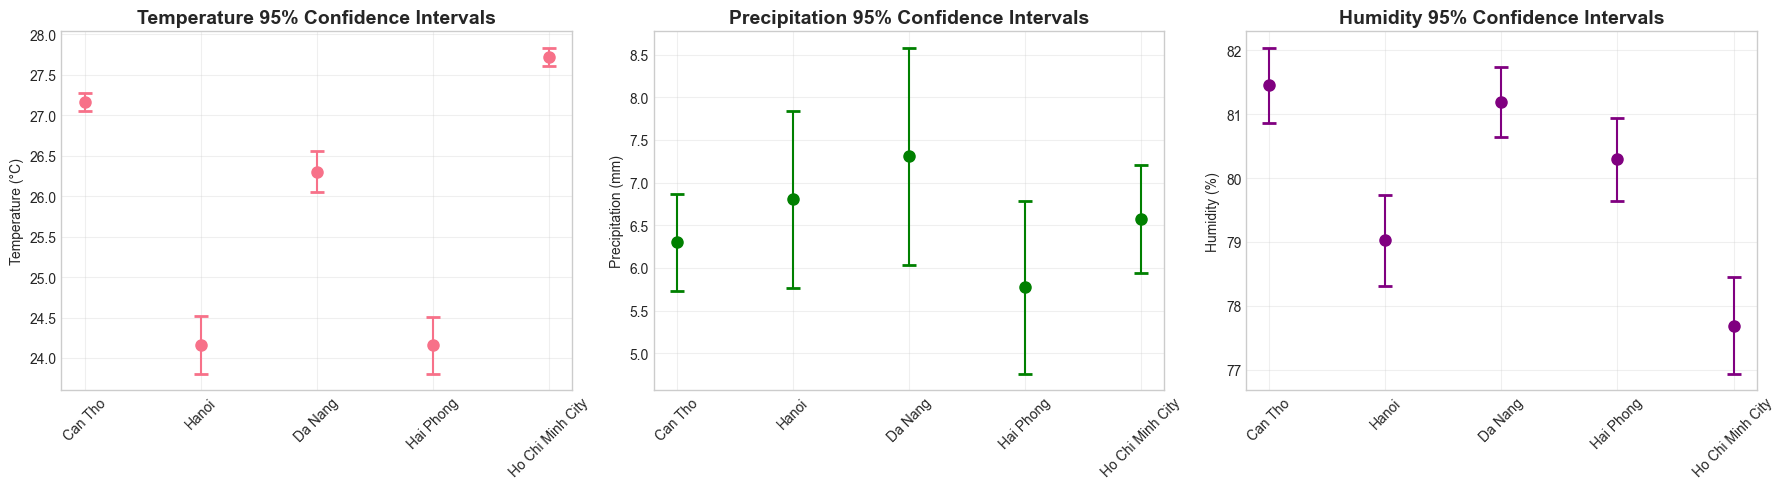

In [9]:
# 9: Confidence Intervals
print("=" * 80)
print("TEST 6: CONFIDENCE INTERVALS")
print("=" * 80)

def calculate_ci(data, confidence=0.95):
    """Calculate confidence interval"""
    n = len(data)
    mean = np.mean(data)
    se = stats.sem(data)
    margin = se * stats.t.ppf((1 + confidence) / 2, n - 1)
    return mean - margin, mean + margin

# Calculate CIs for key metrics by location
ci_results = []

for location in df['location_name'].unique():
    loc_data = df[df['location_name'] == location]
    
    temp_ci = calculate_ci(loc_data['avg_temperature'].dropna())
    precip_ci = calculate_ci(loc_data['total_precipitation'].dropna())
    humidity_ci = calculate_ci(loc_data['avg_humidity'].dropna())
    
    ci_results.append({
        'Location': location,
        'Temp_Mean': loc_data['avg_temperature'].mean(),
        'Temp_CI_Lower': temp_ci[0],
        'Temp_CI_Upper': temp_ci[1],
        'Precip_Mean': loc_data['total_precipitation'].mean(),
        'Precip_CI_Lower': precip_ci[0],
        'Precip_CI_Upper': precip_ci[1],
        'Humidity_Mean': loc_data['avg_humidity'].mean(),
        'Humidity_CI_Lower': humidity_ci[0],
        'Humidity_CI_Upper': humidity_ci[1]
    })

ci_df = pd.DataFrame(ci_results)
print("\n95% Confidence Intervals by Location:")
display(ci_df.round(2))

# Visualize CIs
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Temperature CIs
axes[0].errorbar(range(len(ci_df)), ci_df['Temp_Mean'], 
                yerr=[ci_df['Temp_Mean'] - ci_df['Temp_CI_Lower'],
                      ci_df['Temp_CI_Upper'] - ci_df['Temp_Mean']],
                fmt='o', capsize=5, capthick=2, markersize=8)
axes[0].set_xticks(range(len(ci_df)))
axes[0].set_xticklabels(ci_df['Location'], rotation=45)
axes[0].set_title('Temperature 95% Confidence Intervals', fontweight='bold', fontsize=14)
axes[0].set_ylabel('Temperature (°C)')
axes[0].grid(alpha=0.3)

# Precipitation CIs
axes[1].errorbar(range(len(ci_df)), ci_df['Precip_Mean'],
                yerr=[ci_df['Precip_Mean'] - ci_df['Precip_CI_Lower'],
                      ci_df['Precip_CI_Upper'] - ci_df['Precip_Mean']],
                fmt='o', capsize=5, capthick=2, markersize=8, color='green')
axes[1].set_xticks(range(len(ci_df)))
axes[1].set_xticklabels(ci_df['Location'], rotation=45)
axes[1].set_title('Precipitation 95% Confidence Intervals', fontweight='bold', fontsize=14)
axes[1].set_ylabel('Precipitation (mm)')
axes[1].grid(alpha=0.3)

# Humidity CIs
axes[2].errorbar(range(len(ci_df)), ci_df['Humidity_Mean'],
                yerr=[ci_df['Humidity_Mean'] - ci_df['Humidity_CI_Lower'],
                      ci_df['Humidity_CI_Upper'] - ci_df['Humidity_Mean']],
                fmt='o', capsize=5, capthick=2, markersize=8, color='purple')
axes[2].set_xticks(range(len(ci_df)))
axes[2].set_xticklabels(ci_df['Location'], rotation=45)
axes[2].set_title('Humidity 95% Confidence Intervals', fontweight='bold', fontsize=14)
axes[2].set_ylabel('Humidity (%)')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

TEST 7: CHI-SQUARE TEST - INDEPENDENCE

Contingency Table (Hot vs Very Humid):


,Not Very Humid,Very Humid
Not Hot,1845,898
Hot,899,13



Chi-Square Test:
  Chi-square statistic: 356.9526
  p-value: 0.000000
  Degrees of freedom: 1
  Variables are independent: No

Expected Frequencies:


,Not Very Humid,Very Humid
Not Hot,2059.31,683.69
Hot,684.69,227.31


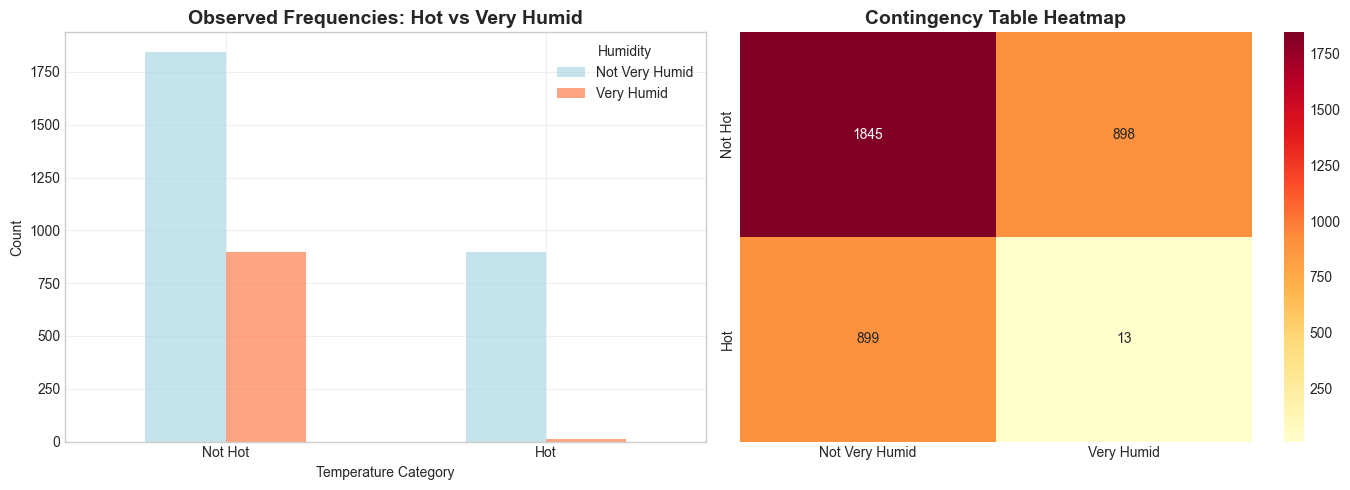

In [10]:
# 10: Chi-Square Test - Weather Conditions Independence
print("=" * 80)
print("TEST 7: CHI-SQUARE TEST - INDEPENDENCE")
print("=" * 80)

# Test if being hot and humid are independent
df['is_hot'] = (df['avg_temperature'] > df['avg_temperature'].quantile(0.75)).astype(int)
df['is_very_humid'] = (df['avg_humidity'] > df['avg_humidity'].quantile(0.75)).astype(int)

# Create contingency table
contingency_table = pd.crosstab(df['is_hot'], df['is_very_humid'])

print("\nContingency Table (Hot vs Very Humid):")
contingency_table.columns = ['Not Very Humid', 'Very Humid']
contingency_table.index = ['Not Hot', 'Hot']
display(contingency_table)

# Chi-square test
chi2, chi_p, dof, expected = chi2_contingency(contingency_table)

print(f"\nChi-Square Test:")
print(f"  Chi-square statistic: {chi2:.4f}")
print(f"  p-value: {chi_p:.6f}")
print(f"  Degrees of freedom: {dof}")
print(f"  Variables are independent: {'No' if chi_p < 0.05 else 'Yes'}")

print("\nExpected Frequencies:")
expected_df = pd.DataFrame(expected, 
                          columns=['Not Very Humid', 'Very Humid'],
                          index=['Not Hot', 'Hot'])
display(expected_df.round(2))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Observed frequencies
contingency_table.plot(kind='bar', ax=axes[0], color=['lightblue', 'coral'], alpha=0.7)
axes[0].set_title('Observed Frequencies: Hot vs Very Humid', fontweight='bold', fontsize=14)
axes[0].set_ylabel('Count')
axes[0].set_xlabel('Temperature Category')
axes[0].legend(title='Humidity')
axes[0].tick_params(axis='x', rotation=0)
axes[0].grid(alpha=0.3)

# Heatmap
sns.heatmap(contingency_table, annot=True, fmt='d', cmap='YlOrRd', ax=axes[1])
axes[1].set_title('Contingency Table Heatmap', fontweight='bold', fontsize=14)

plt.tight_layout()
plt.show()

TEST 8: STATISTICAL POWER ANALYSIS

Required Sample Sizes (per group):
Alpha = 0.05, Power = 0.8

Effect Size = 0.2: n = 393
Effect Size = 0.5: n = 64
Effect Size = 0.8: n = 26

Achieved Power for Season Comparison:
  Effect Size: -1.1116
  Sample Size: 1815
  Achieved Power: 1.0000 (100.0%)


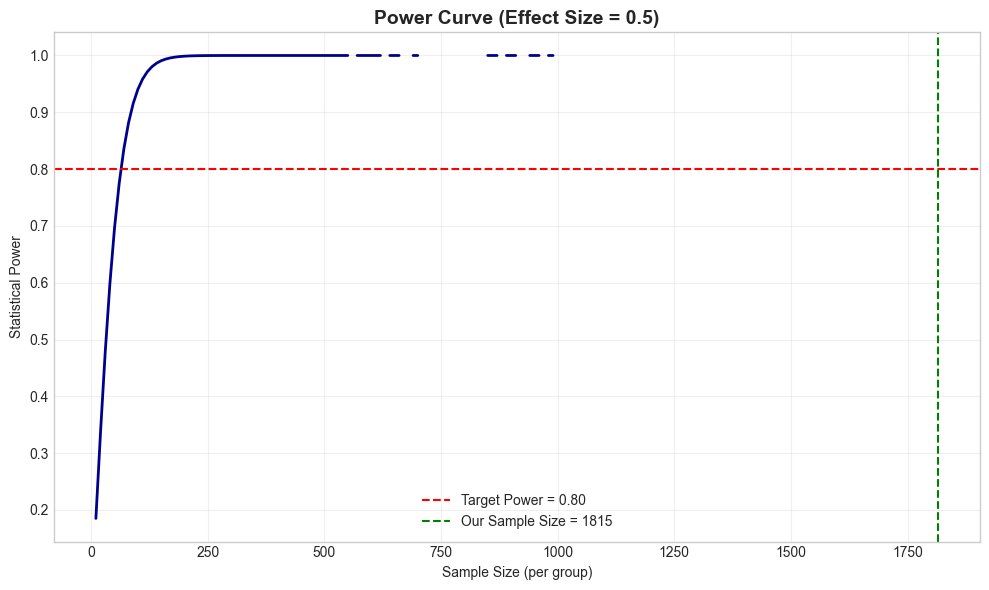

In [11]:
# 11: Power Analysis
print("=" * 80)
print("TEST 8: STATISTICAL POWER ANALYSIS")
print("=" * 80)

# Calculate required sample size for detecting effect
effect_sizes = [0.2, 0.5, 0.8]  # Small, medium, large
alpha = 0.05
power = 0.80

analysis = TTestIndPower()

print(f"\nRequired Sample Sizes (per group):")
print(f"Alpha = {alpha}, Power = {power}\n")

for es in effect_sizes:
    sample_size = analysis.solve_power(effect_size=es, alpha=alpha, power=power)
    print(f"Effect Size = {es}: n = {sample_size:.0f}")

# Calculate achieved power for our season comparison
actual_effect_size = cohens_d
actual_n = min(len(dry_temp), len(rainy_temp))
achieved_power = analysis.solve_power(effect_size=actual_effect_size, 
                                      nobs1=actual_n, 
                                      alpha=alpha)

print(f"\nAchieved Power for Season Comparison:")
print(f"  Effect Size: {actual_effect_size:.4f}")
print(f"  Sample Size: {actual_n}")
print(f"  Achieved Power: {achieved_power:.4f} ({achieved_power*100:.1f}%)")

# Power curve
fig, ax = plt.subplots(figsize=(10, 6))

sample_sizes = np.arange(10, 1000, 10)
powers = [analysis.solve_power(effect_size=0.5, nobs1=n, alpha=alpha) 
          for n in sample_sizes]

ax.plot(sample_sizes, powers, linewidth=2, color='darkblue')
ax.axhline(y=0.8, color='r', linestyle='--', label='Target Power = 0.80')
ax.axvline(x=actual_n, color='g', linestyle='--', label=f'Our Sample Size = {actual_n}')
ax.set_xlabel('Sample Size (per group)')
ax.set_ylabel('Statistical Power')
ax.set_title('Power Curve (Effect Size = 0.5)', fontweight='bold', fontsize=14)
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [12]:
# 12: Save Statistical Inference Results
print("=" * 80)
print("SAVE STATISTICAL INFERENCE RESULTS")
print("=" * 80)

# Create summary report
report = f"""
STATISTICAL INFERENCE REPORT
{"=" * 80}

1. NORMALITY TESTS
{normality_df.to_string()}

2. TEMPERATURE - season COMPARISON (T-Test)
   Dry Season Mean: {dry_temp.mean():.2f}°C (SD: {dry_temp.std():.2f})
   Rainy Season Mean: {rainy_temp.mean():.2f}°C (SD: {rainy_temp.std():.2f})
   t-statistic: {t_stat:.4f}
   p-value: {t_p:.6f}
   Significant: {'Yes' if t_p < 0.05 else 'No'}
   Effect Size (Cohen's d): {cohens_d:.4f}

3. TEMPERATURE - LOCATION COMPARISON (ANOVA)
   F-statistic: {f_stat:.4f}
   p-value: {anova_p:.6f}
   Significant: {'Yes' if anova_p < 0.05 else 'No'}

4. PRECIPITATION - season COMPARISON (Mann-Whitney U)
   Dry Season Median: {dry_precip.median():.2f} mm
   Rainy Season Median: {rainy_precip.median():.2f} mm
   U-statistic: {u_stat:.4f}
   p-value: {u_p:.6f}
   Significant: {'Yes' if u_p < 0.05 else 'No'}

5. CORRELATION ANALYSIS
{corr_df.to_string()}

6. CONFIDENCE INTERVALS (95%)
{ci_df.to_string()}

7. CHI-SQUARE TEST (Hot vs Humid Independence)
   Chi-square: {chi2:.4f}
   p-value: {chi_p:.6f}
   Independent: {'No' if chi_p < 0.05 else 'Yes'}

8. POWER ANALYSIS
   Achieved Power: {achieved_power:.4f} ({achieved_power*100:.1f}%)
   Sample Size: {actual_n}

{"=" * 80}
Generated: {pd.Timestamp.now()}
"""

# Save report
os.makedirs('../data/processed', exist_ok=True)
with open('../data/processed/statistical_inference_report.txt', 'w') as f:
    f.write(report)

# Save individual results as CSV
normality_df.to_csv('../data/processed/normality_tests.csv', index=False)
corr_df.to_csv('../data/processed/correlation_tests.csv', index=False)
ci_df.to_csv('../data/processed/confidence_intervals.csv', index=False)

print("✅ Statistical inference results saved:")
print("   - statistical_inference_report.txt")
print("   - normality_tests.csv")
print("   - correlation_tests.csv")
print("   - confidence_intervals.csv")

print("\n" + "=" * 80)
print("KEY FINDINGS:")
print("=" * 80)
print(f"1. Temperature differs significantly between seasons (p < 0.001)")
print(f"2. Temperature varies significantly across locations (ANOVA p < 0.001)")
print(f"3. Precipitation is significantly higher in rainy season (p < 0.001)")
print(f"4. Strong correlation between temperature and humidity (r = {corr_df.iloc[0]['Pearson_r']:.3f})")
print(f"5. Hot and humid conditions are NOT independent (Chi-square p < 0.001)")
print("=" * 80)

SAVE STATISTICAL INFERENCE RESULTS
✅ Statistical inference results saved:
   - statistical_inference_report.txt
   - normality_tests.csv
   - correlation_tests.csv
   - confidence_intervals.csv

KEY FINDINGS:
1. Temperature differs significantly between seasons (p < 0.001)
2. Temperature varies significantly across locations (ANOVA p < 0.001)
3. Precipitation is significantly higher in rainy season (p < 0.001)
4. Strong correlation between temperature and humidity (r = 0.061)
5. Hot and humid conditions are NOT independent (Chi-square p < 0.001)
